Here is a TensorFlow model to recognize hand signs.

The model will be:

LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

There are 6 classes to classify so I use a softmax layer in the output layer.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
%matplotlib inline
np.random.seed(1)

y = 5


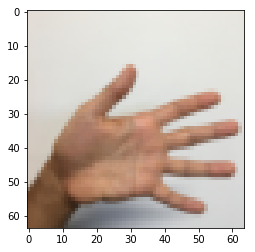

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Each image is 64 x 64 pixels and 3 colors (RGB). So the flattened image will be from 64x64x3 = 12288 and there are 1080 examples so the X_train shape will be (12288,1080)

There are 6 numbers that are in the data set: 0,1,2,3,4,5. So, Y_train shape should be (6, 1080) 6 classes and 1080 examples.

In [3]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [16]:
def create_placeholders(n_x, n_y):
    """
    Creates placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px * RGB = 64 *64 *3 = 12288) 
    n_y -- scalar, number of classes
   
    Returns:
    X -- placeholder for the data input of shape [n_x, None] and dtype float32
    Y -- placeholder for the input labels of shape [n_y, None] and dtype float32
    
    Use None so that it is flexible on the number of examples in the placeholders
    which is needed because number of examples in test/train are different
    """
    
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = 'Y')
    
    return X, Y

def initialize_parameters():
    """
    Initializes parameters to build neural network 
        W1 : [25, 12288] -- 25 units in layer 1
        b1 : [25, 1]
        W2 : [12, 25] -- 12 units in layer 2
        b2 : [12, 1]
        W3 : [6, 12] -- 6 units in layer 3
        b3 : [6, 1]
        
    Returns: 
    parameters -- a dictionary of tensors
    """
    
    tf.set_random_seed (1)
    
    # use Xavier initializer for weights
    W1 = tf.get_variable('W1', [25,12288], initializer=tf.contrib.layers.xavier_initializer(seed =1))
    # initialize biases with zeros
    b1 = tf.get_variable('b1', [25,1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [12,25], initializer=tf.contrib.layers.xavier_initializer(seed =1))
    b2 = tf.get_variable('b2', [12,1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', [6,12], initializer=tf.contrib.layers.xavier_initializer(seed =1))
    b3 = tf.get_variable('b3', [6,1], initializer=tf.zeros_initializer())
    
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2,
                  'W3': W3,
                  'b3': b3
                 }
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements forward prop for model
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- dictionary containing parameters from initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Z1 = W1*X + b1
    Z1 = tf.add(tf.matmul(W1,X),b1)
    # ReLU activation 
    A1 = tf.nn.relu(Z1)        
    # Z2 = W2*A1 + b2
    Z2 = tf.add(tf.matmul(W2, A1),b2)
    A2 = tf.nn.relu(Z2)              
    # Z3 = W3*A2 + b3
    Z3 = tf.add(tf.matmul(W3,A2),b3) 
    
    return Z3

def compute_cost(Z3, Y):
    """
    Computes the softmax cross entropy cost
    
    Arguments:
    Z3 -- output of forward prop (output of the last LINEAR unit), shape: (6, number of examples)
    Y -- "true" label vector placeholder, same shape as Z3
    
    Returns:
    cost -- Tensor of the cost function
    """
    
    # need to transpose Z3 and Y to fit tf.nn.softmax_cross_entropy_with_logits
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # tf.reduce_mean sums over the examples
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
         num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Wraps above functions. 
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    Uses Adam optimizer for backprop
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph() # to rerun the model without overwriting tf variables
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape # store the output of X_train.shape with n_x being num_pixels * num_pixels * 3
    n_y = Y_train.shape[0] # output size. 6 classes
    costs = [] # to record the cost
    
    
    # Adding functions to tensorflow computation graph...
    # create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # initialize parameters
    parameters = initialize_parameters()
    
    # Forward prop
    Z3 = forward_propagation(X, parameters)
        
    # Cost function
    cost = compute_cost(Z3, Y)
    
    # Backprop. Taken care of tensorflow optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # initialize all the variables
    init = tf.global_variables_initializer()
    
    # start session and compute the tensorflow graph
    with tf.Session() as sess:
        
        # run initialization
        sess.run(init)
        
        # training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches in the train set
            seed = seed + 1 # randomize mini batches
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed) # create minibatches
            
            for minibatch in minibatches:
                
                # select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # run the session to execute optimizer and the cost
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
            
            # print epoch cost every 100 epochs
            if print_cost == True and epoch % 100 == 0:
                print('Cost after epoch {}: {}'.format(epoch, epoch_cost))
            # store epoch costs every 5 epochs
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        # save parameters
        parameters = sess.run(parameters)
        print("Parameters trained")
        
        # metrics ...
        
        # calculate correct predictions 
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        # calculate accuracy on test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print('Train Accuracy:', accuracy.eval({X:X_train, Y:Y_train}))
        print('Test Accuracy:', accuracy.eval({X:X_test, Y:Y_test}))
        
        return parameters

Cost after epoch 0: 1.8555827213056157
Cost after epoch 100: 1.646988651969216
Cost after epoch 200: 1.5270396037535232
Cost after epoch 300: 1.4373803680593316
Cost after epoch 400: 1.3555000370199033
Cost after epoch 500: 1.2805933518843218
Cost after epoch 600: 1.2131149768829343
Cost after epoch 700: 1.1523417378916887
Cost after epoch 800: 1.0944697604034888
Cost after epoch 900: 1.0442853515798396
Cost after epoch 1000: 0.992680022210786
Cost after epoch 1100: 0.9423780043919879
Cost after epoch 1200: 0.8994591073556378
Cost after epoch 1300: 0.8559112892006382
Cost after epoch 1400: 0.8128173495783948


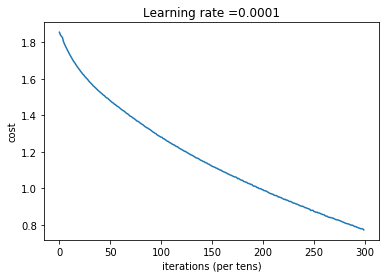

Parameters trained
Train Accuracy: 0.788889
Test Accuracy: 0.691667


In [17]:
# with Gradient Descent
parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 1.8557019089207507
Cost after epoch 100: 1.01645776719758
Cost after epoch 200: 0.7331024751518711
Cost after epoch 300: 0.5729153038877428
Cost after epoch 400: 0.46868511266780605
Cost after epoch 500: 0.3810680504098084
Cost after epoch 600: 0.31380907152638293
Cost after epoch 700: 0.2541457947456476
Cost after epoch 800: 0.203801451758905
Cost after epoch 900: 0.16639340488296567
Cost after epoch 1000: 0.1411411744175535
Cost after epoch 1100: 0.10771775256955264
Cost after epoch 1200: 0.08626101741736586
Cost after epoch 1300: 0.06092442064122719
Cost after epoch 1400: 0.05092670847520684


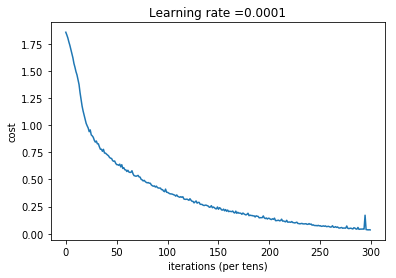

Parameters trained
Train Accuracy: 0.999074
Test Accuracy: 0.725


In [15]:
# with AdamOptimizer
parameters = model(X_train, Y_train, X_test, Y_test)

Adam optimizer learns faster. But it's overfit. Can try regularzation techniques. L2 regularization or drop out.